In [43]:
from langchain_huggingface import ChatHuggingFace
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_huggingface import HuggingFaceEmbeddings


In [44]:
load_dotenv()

True

In [ ]:
# MODEL_ID = "Qwen/Qwen2.5-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    
    trust_remote_code=True,
    device_map = "auto", 
    dtype="auto"
)

pipe = pipeline(
    model = model,
    tokenizer = tokenizer,
    task = 'text-generation',
    max_new_tokens = 256,
    temperature = 0.2
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

ValueError: You are trying to offload the whole model to the disk. Please use the `disk_offload` function instead.

In [ ]:
loader = PyPDFLoader("Data Science from Scratch by Joel Grus.pdf")
docs = loader.load()


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 17 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 26 0 (offset 0)
Ignoring wrong pointing object 30 0 (offset 0)
Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 38 0 (offset 0)
Ignoring wrong pointing object 42 0 (offset 0)
Ignoring wrong pointing object 46 0 (offset 0)
Ignoring wrong pointing object 50 0 (offset 0)
Ignoring wrong pointing object 59 0 (offset 0)
Ignoring wrong pointing object 60 0 (offset 0)
Ignoring wrong pointing object 61 0 (offset 0)
Ignoring wrong pointing object 70 0 (offset 0)
Ignoring wrong pointing object 71 0 (offset 0)
Ignoring wrong pointing object 72 0 (offset 0)
Ignoring wrong pointing object 73 0 (offset 0)
Ignoring wrong pointing object 74 0 (offset 0)
Ignoring wrong pointing object 81 0 (offset 0)
Ignoring wrong

In [ ]:
len(docs)

330

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 200)
chunks = splitter.split_documents(docs)

In [ ]:
len(chunks)

760

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-MiniLM-L6-v2")
vector_store = FAISS.from_documents(chunks, embeddings)                                   

In [ ]:
vector_store

In [ ]:
retriever = vector_store.as_retriever(search_type = "similarity", search_kwargs = {'k':4})

In [ ]:
@tool
def rag_tool(query: str) -> str:
    """
    Retrieve relevant information from the PDF documents.
    Use this tool when the user asks factual or conceptual questions
    that may be answered from the stored documents.
    """

    docs = retriever.invoke(query)

    context = "\n\n".join(
        doc.page_content for doc in docs
    )

    return context

In [ ]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]

In [ ]:
def chat_node(state : ChatState):

    messages = state.get('messages',[])

    response = llm_with_tools.invoke(messages)

    return {'messages' : [response]}

In [ ]:
tool_node = ToolNode(tools)

In [ ]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

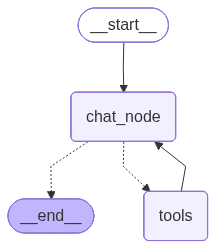

In [ ]:
chatbot

In [ ]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=rag_tool>{"query": "Ideal value of K in KNN"}'}}

In [ ]:
print(result['messages'][-1].content)